# Logistic Regression Model: Predicting sentiment from product reviews


The goal of this first notebook is to explore logistic regression and feature engineering with a model created from scratch.

In this notebook we will use product review data from Amazon.com to predict whether the sentiments about a product (from its reviews) are positive or negative.
## Fire up [Sframe](https://github.com/dato-code/SFrame)

In [1]:
import sframe

## Loading data
amazon_reviews.csv es la unión de varios datasets (ver notebook Data Engineering)

In [2]:
reviews = sframe.SFrame('babies+pets_reviews.csv')

2016-06-13 20:30:56,630 [INFO] sframe.cython.cy_server, 172: SFrame v1.9 started. Logging /tmp/sframe_server_1465842656.log


Read 55898 lines. Lines per second: 46957.8

Unable to parse line ""121431","B0050O92FU","[,0,,, ,0,]","We purchased our Goodbyn lunchboxes at a local retail store recently and the kids have officially started using them. I find that the deep compartments are great to fill with snacks and different variety for school lunc..."

Unable to parse line ""42764","B000FP68KQ","[,0,,, ,0,]","I love this item, very easy to go on easy to use harness clip and she loves to wear it","05 3, 2014","A3IPRBCQK9JWD0","Mz. B$$ ""L. Bennett""","harness dress\","1399075200","love item easy go easy use harness clip love w..."

Unable to parse line ""112687","B0040QOYZ2","[,0,,, ,0,]","I have a Shiba Inu & she sheds SoO much. I bought the Furminator shampoo with the medium long hair comb. When I brush her it's like a razor blade edging her hair off on the top & stripping it. The hair that come off of ..."

Unable to parse line ""123868","B004WSBZAA","[,1,,, ,3,]","I disliked the packaging and lack of information on the product itself and had to go hunting around the internet to find more information on how to administer/feed it to my dog. Powders are generally inconvenient and th..."

4 lines failed to parse correctly

Finished parsing file /Users/digeno/Documents/Cursos/BigData/Kschool-Data-Scientist/proyecto/git/babies+pets_reviews.csv

Parsing completed. Parsed 318624 lines in 4.60895 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,list,str,str,str,str,str,int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


# Exploring Data 1/6
Let us quickly explore more of this dataset.
1. We count the number of positive and negative reviews 
2. list the first 10 products in the dataset.

In [3]:
len(reviews)

318624

In [4]:
reviews.print_rows(num_rows=2, num_columns=10)

+----+------------+-------------------------------+
| X1 |    asin    |            helpful            |
+----+------------+-------------------------------+
| 0  | 097293751X | [None, 0, None, None, None... |
| 1  | 097293751X | [None, 0, None, None, None... |
+----+------------+-------------------------------+
+-------------------------------+-------------+----------------+
|           reviewText          |  reviewTime |   reviewerID   |
+-------------------------------+-------------+----------------+
| Perfect for new parents. W... | 07 16, 2013 | A1HK2FQW6KXQB2 |
| This book is such a life s... | 06 29, 2013 | A19K65VY14D13R |
+-------------------------------+-------------+----------------+
+-------------------------------+-------------------------------+----------------+
|          reviewerName         |            summary            | unixReviewTime |
+-------------------------------+-------------------------------+----------------+
| Amanda Johnsen "Amanda E. ... |            Awes

# Data Engineering: defining reviews with positive or negative sentiment

We'll call data engineering, just defining what is a positive and negative sentiment. So let's do that right now. So in the subsection we're gonna define what's a positive and a negative sentiment.
And so I'm gonna make an arbitrary choice here:
1. Let's say that things that 4, 5 stars are things that people liked. So those are positives. 
2. Things that 1 and 2 stars are negative. 
3. ignore all 3 star reviews.
So I'm gonna say a positive sentiment equals 4 star or 5 star reviews. So let's go ahead and add a new column to our table that defines the actual sentiment. So products new column called sentiment.

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [5]:
reviews = reviews[reviews['review_overall'] != 3]
len(reviews)

285437

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [6]:
reviews['review_sentiment'] = reviews['review_overall'].apply(lambda rating : +1 if rating > 3 else -1)
reviews.print_rows(num_rows=2, num_columns=10)

+----+------------+-------------------------------+
| X1 |    asin    |            helpful            |
+----+------------+-------------------------------+
| 0  | 097293751X | [None, 0, None, None, None... |
| 1  | 097293751X | [None, 0, None, None, None... |
+----+------------+-------------------------------+
+-------------------------------+-------------+----------------+
|           reviewText          |  reviewTime |   reviewerID   |
+-------------------------------+-------------+----------------+
| Perfect for new parents. W... | 07 16, 2013 | A1HK2FQW6KXQB2 |
| This book is such a life s... | 06 29, 2013 | A19K65VY14D13R |
+-------------------------------+-------------+----------------+
+-------------------------------+-------------------------------+----------------+
|          reviewerName         |            summary            | unixReviewTime |
+-------------------------------+-------------------------------+----------------+
| Amanda Johnsen "Amanda E. ... |            Awes

### Subsample dataset to make sure classes are balanced
Just as we did in the previous assignment, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We use `seed=1` so everyone gets the same results.

In [7]:
positive_reviews_raw = reviews[reviews['review_sentiment'] == 1]
negative_reviews_raw  = reviews[reviews['review_sentiment'] == -1]

# Undersample the reviews.
percentage = len(negative_reviews_raw)/float(len(positive_reviews_raw))
negative_reviews = negative_reviews_raw
positive_reviews = positive_reviews_raw.sample(percentage, seed=1)
products = negative_reviews_raw.append(positive_reviews)

print "Percentage of positive reviews             :", len(positive_reviews) / float(len(products))
print "Percentage of negative reviews             :", len(negative_reviews) / float(len(products))
print "Total number of reviews in our new dataset :", len(products)

Percentage of positive reviews             : 0.50116556825
Percentage of negative reviews             : 0.49883443175
Total number of reviews in our new dataset : 69494


# Exploring Data 2/6
Let us quickly explore more of this dataset.
1. We count the number of positive and negative reviews.
2. Modify the subset to contain similar numbers of positive and negative reviews, as the original dataset consisted primarily of positive reviews.

In [8]:
print '# of positive reviews =', len(reviews[reviews['review_sentiment']==1])
print '# of negative reviews =', len(reviews[reviews['review_sentiment']==-1])

# of positive reviews = 250771
# of negative reviews = 34666


In [9]:
print '# of positive balanced reviews =', len(products[products['review_sentiment']==1])
print '# of negative balanced reviews =', len(products[products['review_sentiment']==-1])

# of positive balanced reviews = 34828
# of negative balanced reviews = 34666


# Reviews Extraction Phase: data preparation. 
## (developed in the Data Engineering notebook)
**Note:** 
 - column review_clean with text cleaning developed in Data Engineering notebook
 - building features: la lista de palabras important_words.json se confecciona en el nb Data Engineering

**Note:** There are several ways of doing this. We use the built-in *count* function for Python lists. Each **review without punctuation, stopwords, etc** string is first split into individual words and the number of occurances of a given word is counted.
1. Transform the reviews into word-counts (only for **important_words**, without punctuation, stopwords, etc)
2. For each word in **important_words**, we compute a count for the number of times the word occurs in the review. We will store this count in a separate column (one for each word). The result of this feature processing is a single column for each word in **important_words** which keeps a count of the number of times the respective word occurs in the review text.

Now, we will load these words from this JSON file:

In [10]:
import json
with open('important_words_1500.json', 'r') as f: # Reads the list of words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

In [11]:
len(important_words)

1500

In [12]:
print important_words

['i', 'wa', 'one', 'the', 'dog', 'like', 'love', 'it', 'baby', 'get', 'would', 'use', 'great', 'ha', 'cat', 'this', 'my', 'time', 'little', 'well', 'really', 'product', 'toy', 'also', 'good', 'dont', 'much', 'we', 'month', 'work', 'food', 'easy', 'make', 'put', 'old', 'even', 'seat', 'still', 'bought', 'bag', 'keep', 'used', 'they', 'thing', 'two', 'fit', 'back', 'first', 'go', 'bottle', 'doesnt', 'around', 'its', 'doe', 'small', 'day', 'im', 'got', 'using', 'size', 'need', 'take', 'water', 'think', 'son', 'since', 'year', 'better', '2', 'could', 'enough', 'didnt', 'recommend', 'way', 'buy', 'nice', 'made', 'diaper', 'price', 'clean', 'lot', 'come', 'treat', 'look', 'problem', 'he', 'long', 'big', 'bit', 'ive', 'she', 'see', 'daughter', 'car', 'side', 'every', 'play', 'want', 'hold', 'give', 'know', 'stroller', 'sure', 'so', 'right', '3', 'cant', 'week', 'if', 'these', 'perfect', 'seems', 'box', 'though', 'without', 'easily', 'tried', 'never', 'litter', 'but', 'say', 'soft', 'cup', 'ne

In [13]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

# Exploring Data 3/6

The SFrame **products** now contains one column for each of the **important_words**. As an example, the column **perfect** contains a count of the number of times the word **perfect** occurs in each of the reviews.

In [14]:
products['perfect']

dtype: int
Rows: 69494
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... ]

Now, write some code to compute the number of product reviews that contain the word **perfect**.
* First create a column called `contains_perfect` which is set to 1 if the count of the word **perfect** (stored in column **perfect**) is >= 1.
* Sum the number of 1s in the column `contains_perfect`.

In [15]:
products['contains_perfect'] = products['perfect'].apply(lambda s : +1 if s >= 1 else 0)

In [16]:
products['contains_perfect'].sum()

3516

# Implementing logistic regression from scratch

## link function (estimating conditional probability)

Recall from lecture that the link function is given by:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ represents the word counts of **important_words** in the review  $\mathbf{x}_i$.

In [17]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''

def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    scores = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1.0 / (1.0 + np.exp(-scores))

    return predictions

How the link function works with matrix algebra?

Since the word counts are stored as columns in **feature_matrix**, each $i$-th row of the matrix corresponds to the feature vector $h(\mathbf{x}_i)$:
$$
[\text{feature_matrix}] =
\left[
\begin{array}{c}
h(\mathbf{x}_1)^T \\
h(\mathbf{x}_2)^T \\
\vdots \\
h(\mathbf{x}_N)^T
\end{array}
\right] =
\left[
\begin{array}{cccc}
h_0(\mathbf{x}_1) & h_1(\mathbf{x}_1) & \cdots & h_D(\mathbf{x}_1) \\
h_0(\mathbf{x}_2) & h_1(\mathbf{x}_2) & \cdots & h_D(\mathbf{x}_2) \\
\vdots & \vdots & \ddots & \vdots \\
h_0(\mathbf{x}_N) & h_1(\mathbf{x}_N) & \cdots & h_D(\mathbf{x}_N)
\end{array}
\right]
$$

By the rules of matrix multiplication, the score vector containing elements $\mathbf{w}^T h(\mathbf{x}_i)$ is obtained by multiplying **feature_matrix** and the coefficient vector $\mathbf{w}$.
$$
[\text{score}] =
[\text{feature_matrix}]\mathbf{w} =
\left[
\begin{array}{c}
h(\mathbf{x}_1)^T \\
h(\mathbf{x}_2)^T \\
\vdots \\
h(\mathbf{x}_N)^T
\end{array}
\right]
\mathbf{w}
= \left[
\begin{array}{c}
h(\mathbf{x}_1)^T\mathbf{w} \\
h(\mathbf{x}_2)^T\mathbf{w} \\
\vdots \\
h(\mathbf{x}_N)^T\mathbf{w}
\end{array}
\right]
= \left[
\begin{array}{c}
\mathbf{w}^T h(\mathbf{x}_1) \\
\mathbf{w}^T h(\mathbf{x}_2) \\
\vdots \\
\mathbf{w}^T h(\mathbf{x}_N)
\end{array}
\right]
$$

## Compute derivative of log likelihood with respect to a single coefficient

Recall:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

Function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. The function accepts two arguments:
* `errors` vector containing $\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})$ for all $i$.
* `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$. 

In [18]:
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)
    
    # Return the derivative
    return derivative

We introduced a transformation of this likelihood---called the log likelihood---that simplifies the derivation of the gradient and is more numerically stable.  Due to its numerical stability, we will use the log likelihood instead of the likelihood to assess the algorithm.

The log likelihood is computed using the following formula (see the advanced optional video if you are curious about the derivation of this equation):

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

Function to compute the log likelihood for the entire dataset.

In [19]:
def compute_log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicator-1)*scores - logexp)
    return lp

## Taking gradient steps
Now we are ready to implement our own logistic regression. 

Function to solve the logistic regression model using gradient ascent:

In [20]:
from math import sqrt

def logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):

        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            derivative = np.dot(errors,feature_matrix[:,j])
            
            # add the step size times the derivative to the current coefficient
            coefficients[j] = coefficients[j] + derivative*step_size
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood(feature_matrix, sentiment, coefficients)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    return coefficients

# Resolving a sentiment classifier with logistic regression

## Split data into training and test sets
Let's perform a train/test split with 80% of the data in the training set and 20% of the data in the test set. We use `seed=1` so that everyone gets the same result.

In [21]:
train_data, test_data = products.random_split(.8, seed=1)

In [ ]:
# Warning: This may take a few minutes...
print '# of total reviews =', len(products)
print '# of positive reviews on all data =', len(products[products['review_sentiment']==1])
print '# of negative reviews on all data =', len(products[products['review_sentiment']==-1])

In [ ]:
# Warning: This may take a few minutes...
print '# of train_data reviews =', len(train_data)
print '# of positive reviews on train data =', len(train_data[train_data['review_sentiment']==1])
print '# of negative reviews on train data =', len(train_data[train_data['review_sentiment']==-1])

In [ ]:
# Warning: This may take a few minutes...
print '# of test_data reviews =', len(test_data)
print '# of positive reviews on test data =', len(test_data[test_data['review_sentiment']==1])
print '# of negative reviews on test data =', len(test_data[test_data['review_sentiment']==-1])

## SFrame to NumPy array
NumPy is a powerful library for doing matrix manipulation. Let us convert our data to matrices and then implement our algorithms with matrices.

Function that extracts columns from an SFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels. The feature matrix includes an additional column 'intercept' to take account of the intercept term.

In [24]:
import numpy as np
def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

def get_numpy_feature_matrix(data_sframe, features):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    return(feature_matrix)

# Training Set

Let us convert the train_data into NumPy arrays.

In [25]:
# Warning: This may take a few minutes...
train_feature_matrix, train_sentiment = get_numpy_data(train_data, important_words, 'review_sentiment') 

In [26]:
train_feature_matrix.shape

(55656, 1501)

## Creating the sentiment classifier on the training data

In [27]:
# Warning: This may take a few minutes...
sentiment_model_coefficients = logistic_regression(train_feature_matrix, train_sentiment, initial_coefficients=np.zeros(train_feature_matrix.shape[1]),
                                   step_size=1e-7, max_iter=301)

iteration   0: log likelihood of observed labels = -38567.58570502
iteration   1: log likelihood of observed labels = -38557.40576277
iteration   2: log likelihood of observed labels = -38547.25921528
iteration   3: log likelihood of observed labels = -38537.14563207
iteration   4: log likelihood of observed labels = -38527.06459114
iteration   5: log likelihood of observed labels = -38517.01567885
iteration   6: log likelihood of observed labels = -38506.99848975
iteration   7: log likelihood of observed labels = -38497.01262643
iteration   8: log likelihood of observed labels = -38487.05769931
iteration   9: log likelihood of observed labels = -38477.13332656
iteration  10: log likelihood of observed labels = -38467.23913387
iteration  11: log likelihood of observed labels = -38457.37475437
iteration  12: log likelihood of observed labels = -38447.53982844
iteration  13: log likelihood of observed labels = -38437.73400357
iteration  14: log likelihood of observed labels = -38427.9569

## Class predictions from scores

Class predictions for a data point $\mathbf{x}$ can be computed from the coefficients $\mathbf{w}$ using the following formula:
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & \mathbf{x}_i^T\mathbf{w} > 0 \\
      -1 & \mathbf{x}_i^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

Now, we will write some code to compute class predictions. We will do this in two steps:
* **Step 1**: First compute the **scores** using **feature_matrix** and **coefficients** using a dot product.
* **Step 2**: Using the formula above, compute the class predictions from the scores.

Step 1 can be implemented as follows:

In [28]:
# Step 1: Compute the scores as a dot product between feature_matrix and coefficients.
scores = np.dot(train_feature_matrix, sentiment_model_coefficients)

In [29]:
# Step 2: compute the class predictions using the **scores** obtained above:
train_sentiment_predictions = map((lambda score: +1 if score > 0 else -1), scores)

## Measuring accuracy of the model

We will now measure the classification accuracy of the model. 
In accuracy, instead of measuring the number of errors, we measure the number of correct classifications.
So the ratio here is number of correct divided by total number of sentences. 
In terms of accuracy, the best possible value is 1, I've got all the sentences right. 
The classification accuracy can be computed as follows:

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$

In [30]:
num_mistakes = (train_sentiment != train_sentiment_predictions).sum()
accuracy = 1.0 * (len(train_data) - num_mistakes) / len(train_data)
print "-----------------------------------------------------"
print '# Reviews   correctly classified =', len(train_data) - num_mistakes
print '# Reviews incorrectly classified =', num_mistakes
print '# Reviews total                  =', len(train_data)
print "-----------------------------------------------------"
print 'Accuracy = %.2f' % accuracy

-----------------------------------------------------
# Reviews   correctly classified = 41572
# Reviews incorrectly classified = 14084
# Reviews total                  = 55656
-----------------------------------------------------
Accuracy = 0.75


# Exploring Data 4/6
## Which words contribute most to positive & negative sentiments?

We were able to compute the "**most positive words**". These are words that correspond most strongly with positive reviews. In order to do this, we will first do the following:
* Treat each coefficient as a tuple, i.e. (**word**, **coefficient_value**).
* Sort all the (**word**, **coefficient_value**) tuples by **coefficient_value** in descending order.

In [31]:
sentiment_model_coefficients_without_intercept = list(sentiment_model_coefficients[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, sentiment_model_coefficients_without_intercept)]

Now, **word_coefficient_tuples** contains a sorted list of (**word**, **coefficient_value**) tuples. The first 10 elements in this list correspond to the words that are most positive.

### Twenty "most positive" words

Now, we compute the 10 words that have the most positive coefficient values. These words are associated with positive sentiment.

In [32]:
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)

In [33]:
word_coefficient_tuples[0:20]

[('love', 0.11574086898576158),
 ('great', 0.077968302180233109),
 ('easy', 0.059461702552197272),
 ('little', 0.04098241971507028),
 ('well', 0.032131608837744685),
 ('ha', 0.029038622747276092),
 ('perfect', 0.027392359136945193),
 ('keep', 0.024880151467029526),
 ('nice', 0.021059042164761621),
 ('happy', 0.018657642532903387),
 ('use', 0.017094764789196252),
 ('best', 0.016504994290409823),
 ('highly', 0.016030180615662373),
 ('size', 0.015279443984973001),
 ('clean', 0.014791679220312015),
 ('bit', 0.014452382567842526),
 ('soft', 0.013700901513913575),
 ('stroller', 0.013401161064797948),
 ('price', 0.012021641771434674),
 ('car', 0.011862034749520682)]

## Fire up [WordCloud](https://github.com/amueller/word_cloud) 

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
%matplotlib inline  


###  Most possitive words cloud

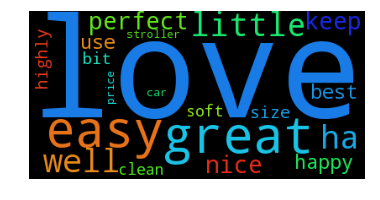

In [35]:
wordcloud = WordCloud(relative_scaling=.1).generate_from_frequencies(word_coefficient_tuples[0:20])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Twenty "most negative" words

Next, we repeat this exercise on the 10 most negative words.  That is, we compute the 10 words that have the most negative coefficient values. These words are associated with negative sentiment.

In [36]:
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=False)

In [37]:
word_coefficient_tuples[0:20]

[('wa', -0.091094216373101208),
 ('would', -0.054711936013178399),
 ('product', -0.035240973743104705),
 ('money', -0.034664203752066899),
 ('didnt', -0.033507620718401847),
 ('even', -0.030034860598779179),
 ('waste', -0.025811857271428353),
 ('thought', -0.023163808370065816),
 ('review', -0.021129820851966217),
 ('disappointed', -0.020120067126427506),
 ('back', -0.019578348029954163),
 ('dont', -0.019506401630479002),
 ('tried', -0.01920563188567247),
 ('return', -0.018993485377733255),
 ('maybe', -0.017677902938593625),
 ('better', -0.017217257242232668),
 ('plastic', -0.016999403389304613),
 ('could', -0.016683823469293469),
 ('doesnt', -0.015998842247745969),
 ('work', -0.015984420236612527)]

### Most negative words cloud

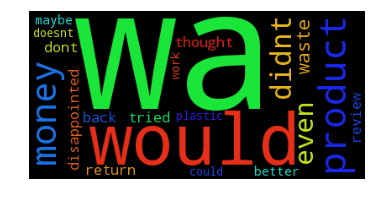

In [38]:
negativeWordsDf = pd.DataFrame(word_coefficient_tuples[0:20], columns=['word','probability'])

def absProbability(row):
    return row["probability"].abs()

negativeWordsDf['probability']=absProbability(negativeWordsDf)
negativeData = [tuple(x) for x in negativeWordsDf.values]
wordcloud = WordCloud(relative_scaling=.5).generate_from_frequencies(negativeData)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Test Set. Making predictions with logistic regression
Now that a model is trained, we can make predictions on the **test data**.

In [39]:
# We need to convert test_data into the sparse matrix format first.
# Warning: This may take a few minutes...
test_feature_matrix, test_sentiment = get_numpy_data(test_data, important_words, 'review_sentiment')

In [40]:
# Step 1: Compute the scores as a dot product between feature_matrix and coefficients.
scores = np.dot(test_feature_matrix, sentiment_model_coefficients)

In [41]:
# Step 2: compute the class predictions using the **scores** obtained above:
test_sentiment_predictions = map((lambda score: +1 if score > 0 else -1), scores)

## Accuracy on Test Set

In [42]:
num_test_mistakes = (test_sentiment != test_sentiment_predictions).sum()
accuracy = 1.0 * (len(test_data) - num_test_mistakes) / len(test_data)
print "-----------------------------------------------------"
print '# Reviews   correctly classified =', len(test_data) - num_test_mistakes
print '# Reviews incorrectly classified =', num_test_mistakes
print '# Reviews total                  =', len(test_data)
print "-----------------------------------------------------"
print 'Accuracy = %.2f' % accuracy

-----------------------------------------------------
# Reviews   correctly classified = 10321
# Reviews incorrectly classified = 3517
# Reviews total                  = 13838
-----------------------------------------------------
Accuracy = 0.75


# Exploring Data 5/6
## Applying the learned model to understand sentiment for reviews

In [43]:
test_data['predicted_sentiment'] = scores

### Most positive reviews

In [44]:
test_data = test_data.sort('predicted_sentiment', ascending=False)

In [45]:
test_data[['predicted_sentiment','review_sentiment','review_overall','reviewText']][0:5]

predicted_sentiment,review_sentiment,review_overall,reviewText
1.27741979665,1,5.0,"I am dog trainer, andbought this 3 years ago. ..."
0.979748956021,1,5.0,I love this car seat andso do my kids. My ...
0.930447010841,1,5.0,I got these from toys rus which is slightly ...
0.918286682049,-1,2.0,"As parents of two littleones, I'd like to say we ..."
0.869751633996,1,5.0,This is the best purchasewe have made for our ...


In [46]:
# Most positive review
test_data[0]['reviewText']

'I am  dog trainer, and bought this 3 years ago. My dogs love it, shelties, and my clients love it. All my board and train dogs love it. Easy set up, easy fold, easy wash cover.  I do not put the cover in the dyer! just air dry. this is sheltie, 23-30 lb weight. go bigger for size. has held up great!  truly a great buy ! for a non chewing dog.  dog lady of forest grove*** my clients have been buying this cot and all say they love it,, dogs really like the feel and support12 clients dog have loved it and demanded their own, a great buy.nov 2011 six more client dogs demand this bed,, great bed buy it.2012 dog bed has needed minor sewing repairs after 80 plus lb dogs want this bed. clients dogs love it. a great buy.'

### Most negative reviews

In [47]:
test_data = test_data.sort('predicted_sentiment', ascending=True)

In [48]:
test_data[['predicted_sentiment','review_sentiment','review_overall','reviewText']][0:5]

predicted_sentiment,review_sentiment,review_overall,reviewText
-2.35141183744,-1,1.0,So I read many reviews onthis product and watched ...
-2.13293039631,-1,1.0,My advice on the BrightStarts Sugar Blossom ...
-1.88767422128,1,4.0,"First, I got this barkcollar after I read ..."
-1.59814959757,-1,1.0,I got this monitorbecause our old one was ...
-1.5695483579,-1,1.0,I purchased the monitorthrough Amazon and was ...


In [49]:
# Most negative review
test_data[0]['reviewText']

"So I read many reviews on this product and watched youtube videos on it as well. Everyone said the same thing and shame on me for not following my gut feeling. I've been in the aquarium hobby for years and this was my first attempt at setting this up the way its supposed to be done according to the directions. First of all, everyone said it leaks. Well, it does, and from a few places. The hose input and output leaks, the bottom screw on access point leaks and overall this is a cheaply made crappy product. Now, am I saying it doesn't work? IDK, but its not working for me simply on the fact that I shouldn't have to completely seal and bond every point of this contraption and use hose clamps which still leak. The directions may as well be a pop up book with no words, unless  you can read some vague chineese symbols if the directions translate into English. It never says what appropriate size hose to use, I tried 1/2 inch and it fits fine, but still leaks. 3/8 seemed too tight. 5/8 too bi

# Exploring Data 6/6: 
# Applying the learned model to discover insights on twitter.

## Tweets Extraction Phase: data preparation. 
### (developed in the Data Engineering notebook)
**Note:** 
 - column text_clean with text cleaning developed in Data Engineering notebook

## Tweets about Flights

In [50]:
tweets_data = sframe.SFrame('USA-flight-tweets.csv')

Unable to parse line ""62","741695305314226176","Patio beers! "

Unable to parse line ""180","741791291663486976","BONDED  FLIGHT  - Patti Warashina #bronze #sculpture #NewMexicoTrue"

Unable to parse line "https://t.co/7T2ql3mbIX https://t.co/dOtIfqwFiE","Sun Jun 12 00:36:40 +0000 2016","35.68122","-105.9271","Santa Fe, NM","bonded flight patti warashina bronze sculpture newmexicotrue http tco7t2ql3mbix http tcodotifqwfie""

Unable to parse line ""202","741814849974341632","Estuvo MEH"

4 lines failed to parse correctly

Finished parsing file /Users/digeno/Documents/Cursos/BigData/Kschool-Data-Scientist/proyecto/git/USA-flight-tweets.csv

Parsing completed. Parsed 100 lines in 0.025539 secs.

Unable to parse line ""62","741695305314226176","Patio beers! "

Unable to parse line ""180","741791291663486976","BONDED  FLIGHT  - Patti Warashina #bronze #sculpture #NewMexicoTrue"

Unable to parse line "https://t.co/7T2ql3mbIX https://t.co/dOtIfqwFiE","Sun Jun 12 00:36:40 +0000 2016","35.68122","-105.9271","Santa Fe, NM","bonded flight patti warashina bronze sculpture newmexicotrue http tco7t2ql3mbix http tcodotifqwfie""

Unable to parse line ""202","741814849974341632","Estuvo MEH"

4 lines failed to parse correctly

Finished parsing file /Users/digeno/Documents/Cursos/BigData/Kschool-Data-Scientist/proyecto/git/USA-flight-tweets.csv

Parsing completed. Parsed 132 lines in 0.014813 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,str,str,float,float,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


In [51]:
len(tweets_data)

132

In [52]:
tweets_data.column_names

<bound method SFrame.column_names of Columns:
	X1	int
	tweet_id	int
	tweet_text	str
	tweet_created_at	str
	tweet_geo_lat	float
	tweet_geo_lon	float
	tweet_city	str
	text_clean	str

Rows: 132

Data:
+----+--------------------+-------------------------------+
| X1 |      tweet_id      |           tweet_text          |
+----+--------------------+-------------------------------+
| 0  | 741538295482617856 | Picture of an emerald humm... |
| 1  | 741545766280265728 | #AUS #SFO Austin Texas -&g... |
| 2  | 741560611327250432 | #LAS #LAX Las Vegas -&gt; ... |
| 3  | 741560864059183104 | #IAD #SFO Washington Dulle... |
| 4  | 741561116753461248 | #DAL #SFO Dallas Love Fiel... |
| 5  | 741561369959354368 | #DAL #LAS Dallas Love Fiel... |
| 6  | 741571697636192257 | Up to 50% Off Frio Bat Fli... |
| 8  | 741610670542757889 | My flight music #kellypric... |
| 13 | 741617791518806016 | Hoping for a uneventful fl... |
| 16 | 741619785570648064 | Photo: Shot of a plane tai... |
+----+----------------

In [53]:
for word in important_words:
    tweets_data[word] = tweets_data['text_clean'].apply(lambda s : s.split().count(word))

In [54]:
# We need to convert test_data into the sparse matrix format first.
# Warning: This may take a few minutes...
tweets_feature_matrix  = get_numpy_feature_matrix(tweets_data, important_words) 

In [55]:
# Step 1: Compute the scores as a dot product between feature_matrix and coefficients.
scores = np.dot(tweets_feature_matrix, sentiment_model_coefficients)

In [56]:
tweets_data['predicted_sentiment'] = scores

### Export to json array to d3 visualization

### Most positive tweets

In [57]:
tweets_data = tweets_data.sort('predicted_sentiment', ascending=False)

In [58]:
tweets_data[['tweet_id','predicted_sentiment','tweet_text','tweet_geo_lat','tweet_geo_lon','tweet_city']][0:2]

tweet_id,predicted_sentiment,tweet_text,tweet_geo_lat,tweet_geo_lon,tweet_city
741561369959354368,0.126829765846,#DAL #LAS Dallas LoveField -&gt; Las Vegas ...,32.8472,-96.8517,"Dallas, TX"
741938859408166912,0.126829765846,#DAL #SFO Dallas LoveField -&gt; San Franc ...,32.8472,-96.8517,"Dallas, TX"


In [59]:
positive_tweets_data = tweets_data[['tweet_id','predicted_sentiment','tweet_text','tweet_geo_lat','tweet_geo_lon','tweet_city']][0:4]

In [60]:
positive_tweets_data.export_json('d3/data/USA-flight-tweets-positive.json')

### Most negative tweets

In [61]:
tweets_data = tweets_data.sort('predicted_sentiment', ascending=True)

In [62]:
tweets_data[['tweet_id','predicted_sentiment','tweet_text','tweet_geo_lat','tweet_geo_lon','tweet_city']][0:2]

Columns:
	tweet_id	int
	predicted_sentiment	float
	tweet_text	str
	tweet_geo_lat	float
	tweet_geo_lon	float
	tweet_city	str

Rows: 2

Data:
+--------------------+---------------------+-------------------------------+
|      tweet_id      | predicted_sentiment |           tweet_text          |
+--------------------+---------------------+-------------------------------+
| 741636783474151424 |    -0.08196102335   | Damn this was an annoying ... |
| 741723709187166209 |   -0.0800053195129  | Minis for the flight (at @... |
+--------------------+---------------------+-------------------------------+
+---------------+---------------+------------------+
| tweet_geo_lat | tweet_geo_lon |    tweet_city    |
+---------------+---------------+------------------+
|  39.71517597  |  -86.29765034 | Indianapolis, IN |
|   47.832662   |  -122.269813  |   Lynnwood, WA   |
+---------------+---------------+------------------+
[2 rows x 6 columns]

In [63]:
negative_tweets_data = tweets_data[['tweet_id','predicted_sentiment','tweet_text','tweet_geo_lat','tweet_geo_lon','tweet_city']][0:4]

In [64]:
negative_tweets_data.export_json('d3/data/USA-flight-tweets-negative.json')

## Tweets about Cars

In [65]:
tweets_data = sframe.SFrame('USA-car-tweets.csv')

Unable to parse line ""55","741360300167974912","(PJ) grrr"

Unable to parse line "(PJ) a car alarm is going off"

Unable to parse line "(PJ) OH FOR GOD SHAKES SOMEONE SHOOT THE DAMN CAR"

Unable to parse line "(PJ) fuck"

Unable to parse line "(PJ) its our car","Fri Jun 10 20:04:04 +0000 2016","37.69922821","-123.01191117","California, USA","pj grrr pj car alarm going pj oh for god shakes someone shoot the damn car pj fuck pj car""

Unable to parse line ""162","741413276412579840","Ludlow St. "

Unable to parse line ""128","741395769866002432","So I'm watching Cops and two things stuck out to me."

Unable to parse line ""64","741363403390877697","#BeatTheHeat"

Unable to parse line "1. This cop pulled someone over and opened their car door "

Unable to parse line "2. The cop wearing shorts","Fri Jun 10 22:25:00 +0000 2016","40.7969277","-73.9437432","Manhattan, NY","so i m watching cops two thing stuck 1 this cop pulled someone opened car door 2 the cop wearing short""

Unable to parse line ""69","741366752710295552","Call Crystal Coleman 703-899-5949"

12 lines failed to parse correctly

Finished parsing file /Users/digeno/Documents/Cursos/BigData/Kschool-Data-Scientist/proyecto/git/USA-car-tweets.csv

Parsing completed. Parsed 100 lines in 0.024562 secs.

Unable to parse line ""55","741360300167974912","(PJ) grrr"

Unable to parse line ""128","741395769866002432","So I'm watching Cops and two things stuck out to me."

Unable to parse line "(PJ) a car alarm is going off"

Unable to parse line ""162","741413276412579840","Ludlow St. "

Unable to parse line "1. This cop pulled someone over and opened their car door "

Unable to parse line "(PJ) OH FOR GOD SHAKES SOMEONE SHOOT THE DAMN CAR"

Unable to parse line "2. The cop wearing shorts","Fri Jun 10 22:25:00 +0000 2016","40.7969277","-73.9437432","Manhattan, NY","so i m watching cops two thing stuck 1 this cop pulled someone opened car door 2 the cop wearing short""

Unable to parse line "(PJ) fuck"

Unable to parse line "(PJ) its our car","Fri Jun 10 20:04:04 +0000 2016","37.69922821","-123.01191117","California, USA","pj grrr pj car alarm going pj oh for god shakes someone shoot the damn car pj fuck pj car""

Unable to parse line ""64","741363403390877697","#BeatTheHeat"

12 lines failed to parse correctly

Finished parsing file /Users/digeno/Documents/Cursos/BigData/Kschool-Data-Scientist/proyecto/git/USA-car-tweets.csv

Parsing completed. Parsed 122 lines in 0.009474 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,str,str,float,float,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


In [66]:
len(tweets_data)

122

In [67]:
for word in important_words:
    tweets_data[word] = tweets_data['text_clean'].apply(lambda s : s.split().count(word))

In [68]:
# We need to convert test_data into the sparse matrix format first.
# Warning: This may take a few minutes...
tweets_feature_matrix  = get_numpy_feature_matrix(tweets_data, important_words)

In [69]:
# Step 1: Compute the scores as a dot product between feature_matrix and coefficients.
scores = np.dot(tweets_feature_matrix, sentiment_model_coefficients)

In [70]:
tweets_data['predicted_sentiment'] = scores

### Most positive tweets

In [71]:
tweets_data = tweets_data.sort('predicted_sentiment', ascending=False)

In [72]:
positive_tweets_data = tweets_data[['tweet_id','predicted_sentiment','tweet_text','tweet_geo_lat','tweet_geo_lon','tweet_city']][0:4]

In [73]:
positive_tweets_data.export_json('d3/data/USA-car-tweets-positive.json')

### Most negative tweets

In [74]:
tweets_data = tweets_data.sort('predicted_sentiment', ascending=True)

In [75]:
negative_tweets_data = tweets_data[['tweet_id','predicted_sentiment','tweet_text','tweet_geo_lat','tweet_geo_lon','tweet_city']][0:4]

In [76]:
negative_tweets_data.export_json('d3/data/USA-car-tweets-negative.json')

# Most positives and negatives tweets of EEUU dashboard
# (about Flights and Cars)

In [77]:
from IPython.display import IFrame

def serve_html():
    fn= './d3/html/tweets_map.html'
    return IFrame(fn, 985, 570)

In [78]:
serve_html()